# <font color='#3e9dbf'>Import Library and Data</font>

In [224]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix

In [225]:
dataset = pd.read_csv('./customer_churn_data.csv')

# <font color='#3e9dbf'>Function</font>

## <font color='#e89c9a'><ul><li>Show Categorical</li></ul></font>

In [226]:
def show_categorical_describe(attr_name, data=dataset):

  result_table = pd.DataFrame({
    '': ['Unique', 'Top', 'Frequency'],
    'Value': [
      len(data[attr_name].unique()), 
      data[attr_name].describe()['top'], 
      data[attr_name].describe()['freq'],
    ],
  })

  
  return result_table

In [227]:
def show_categorical_values(attr_name, data=dataset):
  result_table = pd.DataFrame(
    [
      {
        'Name': value,
        'Total': data[attr_name].value_counts()[value],
        'Non-Churn': data[(data[attr_name] == value) & (data['Churn'] == 'No')].shape[0],
        'Churn': data[(data[attr_name] == value) & (data['Churn'] == 'Yes')].shape[0],
      }
      for value in data[attr_name].unique()
    ]
  )
  return result_table

## <font color='#e89c9a'><ul><li>Show Statistic values</li></ul></font>

In [228]:
def showStatistics(attr_name, data=dataset, places=3):
  
  stats = data[attr_name].describe(percentiles=[.25, .5, .75])
  skewness = data[attr_name].skew()
  mode = data[attr_name].mode()[0]
  
  stats_table = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Mode', 'SD', 'Var', 'Min', 'Q₁', 'Q₂', 'Q₃', 'Max', 'Skew'],
    'Value': [
      round(stats['mean'], places),
      round(stats['50%'], places),
      round(mode, places),
      round(data[attr_name].std(), places),
      round(data[attr_name].var(), places),
      round(stats['min'], places),
      round(stats['25%'], places),
      round(stats['50%'], places),
      round(stats['75%'], places),
      round(stats['max'], places),
      round(skewness, places)
    ]
  })
  
  return stats_table

## <font color='#e89c9a'><ul><li>Plot Histograms with KDE</li></ul></font>

In [229]:
def plot_hist_kde(attr_name, data=dataset):
  churn = data[data['Churn'] == 'Yes'][attr_name]
  non_churn = data[data['Churn'] == 'No'][attr_name]

  plt.figure(figsize=(8, 5))
  sns.histplot(churn, color='#ad4000', label='Churn', kde=True)
  sns.histplot(non_churn, color='#006dad', label='Non-Churn', kde=True)
  
  plt.xlabel(attr_name, fontsize=14)
  plt.ylabel('Frequency', fontsize=14)

  plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
  plt.gca().set_facecolor("none")
  plt.gcf().set_facecolor("none")
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
  plt.show()

## <font color='#e89c9a'><ul><li>Plot Boxplot</li></ul></font>

In [230]:
def plot_boxplot(attr_name, data=dataset):
  ax = sns.boxplot(data=data[attr_name], color='#006dad')
  ax.set_facecolor("none")

  ax.spines['top'].set_color('#4c4b49')
  ax.spines['right'].set_color('#4c4b49')
  ax.spines['left'].set_color('#4c4b49')
  ax.spines['bottom'].set_color('#4c4b49')

  ax.tick_params(axis='both', colors='#4c4b49')
  plt.gcf().set_facecolor("none")
  plt.show()

  Q1 = data[attr_name].quantile(0.25)
  Q3 = data[attr_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  bounds_table = pd.DataFrame({
    'Statistic': ['Q₁', 'Q₃', 'IQR', 'Lower Bound', 'Upper Bound'],
    'Value': [Q1, Q3, IQR, lower_bound, upper_bound]
  })

  return bounds_table

## <font color='#e89c9a'><ul><li>Plot Comparison Boxplot</li></ul></font>

In [231]:
def plot_comparison_boxplot(attr_name, data=dataset):
  
  title = ' '.join([word.capitalize() for word in attr_name.split()])
  palette = {'No': '#006dad', 'Yes': '#ad4000'}

  plt.figure(figsize=(6, 7))
  sns.boxplot(x='Churn', y=attr_name, hue='Churn', data=data, palette=palette, dodge=False, legend=False).set_facecolor("none")
  plt.xlabel('Churn', fontsize=16)
  plt.ylabel(title, fontsize=16)
  plt.gcf().set_facecolor("none")
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
  plt.legend(frameon=False, fontsize=16, labels=['Non-Churn', 'Churn'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
  plt.show()

  stats_list = []

  for class_name, group in data.groupby('Churn'):
    stats = {
      'Class': 'Non-Churn' if class_name == 'No' else 'Churn',
      'Q₁': round(group[attr_name].quantile(.25), 5),
      'Q₃': round(group[attr_name].quantile(.75), 5),
    }
    stats_list.append(stats)

  return pd.DataFrame(stats_list)


## <font color='#e89c9a'><ul><li>Plot Confusion Matrix</li></ul></font>

In [232]:
def plot_confusion_matrix(cm):

	classes = ['Non-Churn', 'Churn']
	cmap = plt.cm.Blues
	norm = plt.Normalize(vmin=cm.min(), vmax=cm.max())  # normalization แบบเดียวกับ imshow

	plt.figure(figsize=(10, 10))
	plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=norm)
	plt.colorbar(aspect=4)

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, size=18)
	plt.yticks(tick_marks, classes, size=18)

	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
			# ใช้ colormap กับค่าที่ normalize แล้ว
			rgba = cmap(norm(cm[i, j]))
			r, g, b = rgba[:3]
			luminance = 0.299 * r + 0.587 * g + 0.114 * b

			text_color = 'black' if luminance > 0.5 else 'white'
			plt.text(j, i, format(cm[i, j], 'd'), fontsize=30, horizontalalignment="center", color=text_color)

	plt.gca().set_facecolor('none')
	plt.grid(False)
	plt.tight_layout()
	plt.ylabel('Actual', size=16)
	plt.xlabel('Predicted', size=16, labelpad=20)

	plt.show()

## <font color='#e89c9a'><ul><li>Plot Learning Curve</li></ul></font>

In [233]:
def plot_learning_curve(model, x, y):
	cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

	train_sizes, train_scores, val_scores = learning_curve(
		model, x, y, cv=cv, scoring='accuracy',
		train_sizes=np.linspace(0.1, 1.0, 10)
	)

	train_scores_mean = np.mean(train_scores, axis=1)
	val_scores_mean = np.mean(val_scores, axis=1)

	plt.figure(figsize=(8, 6))
	plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
	plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
	plt.title("Learning Curve")
	plt.xlabel("Training Examples")
	plt.ylabel("Accuracy")
	plt.legend(loc="best")
	plt.grid(True)
	plt.show()

# <font color='#3e9dbf'>Dataset Info</font>

In [234]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5880 non-null   object 
 1   gender            5880 non-null   object 
 2   SeniorCitizen     5880 non-null   int64  
 3   Partner           5880 non-null   object 
 4   Dependents        5880 non-null   object 
 5   tenure            5880 non-null   int64  
 6   PhoneService      5880 non-null   object 
 7   MultipleLines     5880 non-null   object 
 8   InternetService   5880 non-null   object 
 9   OnlineSecurity    5880 non-null   object 
 10  OnlineBackup      5880 non-null   object 
 11  DeviceProtection  5880 non-null   object 
 12  TechSupport       5880 non-null   object 
 13  StreamingTV       5880 non-null   object 
 14  StreamingMovies   5880 non-null   object 
 15  Contract          5880 non-null   object 
 16  PaperlessBilling  5880 non-null   object 


In [235]:
dataset.head(len(dataset))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,CUST5875,Male,0,Yes,Yes,71,Yes,No,DSL,Yes,...,No,Yes,No,No,Month-to-month,Yes,Mailed check,74.21,5268.91,No
5876,CUST5876,Male,0,No,No,22,Yes,Yes,DSL,No,...,Yes,Yes,No,Yes,One year,No,Mailed check,65.43,1439.46,Yes
5877,CUST5877,Female,0,No,No,68,No,No phone service,Fiber optic,Yes,...,Yes,Yes,Yes,No,One year,Yes,Bank transfer,59.78,4065.04,No
5878,CUST5878,Female,0,Yes,Yes,14,No,No phone service,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,91.88,1286.32,No


# <font color='#3e9dbf'>Data Preprocess</font>

In [236]:
preprocessed_dataset = dataset.copy()

## <font color='#e89c9a'><ul><li>Drop Feature</li></ul></font>

In [237]:
preprocessed_dataset.drop(columns=['customerID'], inplace=True)
preprocessed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5880 non-null   object 
 1   SeniorCitizen     5880 non-null   int64  
 2   Partner           5880 non-null   object 
 3   Dependents        5880 non-null   object 
 4   tenure            5880 non-null   int64  
 5   PhoneService      5880 non-null   object 
 6   MultipleLines     5880 non-null   object 
 7   InternetService   5880 non-null   object 
 8   OnlineSecurity    5880 non-null   object 
 9   OnlineBackup      5880 non-null   object 
 10  DeviceProtection  5880 non-null   object 
 11  TechSupport       5880 non-null   object 
 12  StreamingTV       5880 non-null   object 
 13  StreamingMovies   5880 non-null   object 
 14  Contract          5880 non-null   object 
 15  PaperlessBilling  5880 non-null   object 
 16  PaymentMethod     5880 non-null   object 


## <font color='#e89c9a'><ul><li>Handling Outliers</li></ul></font>

In [238]:
def plot_outliers_boxplot(dataset, attr_name, color):
  plt.figure(figsize=(3, 7))
  sns.boxplot(data=dataset[attr_name], color=color, orient='v')
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.gca().set_facecolor("none")
  plt.gcf().set_facecolor("none")
  plt.show()

  Q1 = dataset[attr_name].quantile(0.25)
  Q3 = dataset[attr_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  bounds_table = pd.DataFrame({
    'Statistic': ['Q₁', 'Q₃', 'IQR', 'Lower Bound', 'Upper Bound'],
    'Value': [Q1, Q3, IQR, lower_bound, upper_bound]
  })

  return bounds_table

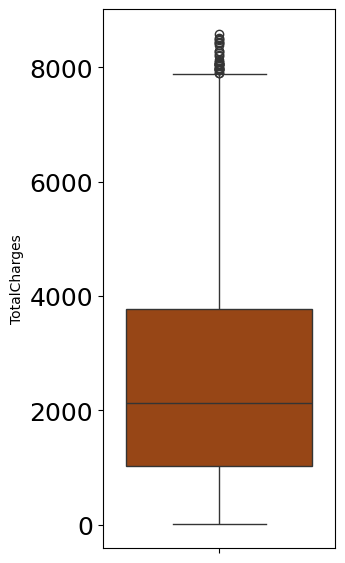

,Statistic,Value
0,Q₁,1020.21750
1,Q₃,3767.66500
2,IQR,2747.44750
3,Lower Bound,-3100.95375
4,Upper Bound,7888.83625


In [239]:
plot_outliers_boxplot(preprocessed_dataset, 'TotalCharges', '#ad4000')

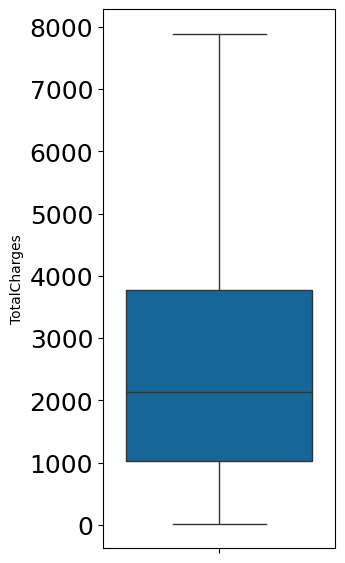

,Statistic,Value
0,Q₁,1020.21750
1,Q₃,3767.66500
2,IQR,2747.44750
3,Lower Bound,-3100.95375
4,Upper Bound,7888.83625


In [240]:
preprocessed_dataset['TotalCharges'] = preprocessed_dataset['TotalCharges'].clip(lower=-3100.95375, upper=7888.83625)
plot_outliers_boxplot(preprocessed_dataset, 'TotalCharges', '#006dad')

## <font color='#e89c9a'><ul><li>Feature Scaling</li></ul></font>

In [241]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
						 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
						 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
						 'PaperlessBilling', 'PaymentMethod']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
	preprocessed_dataset[col] = label_encoder.fit_transform(preprocessed_dataset[col])

preprocessed_dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,23,0,1,2,1,1,1,1,1,1,0,1,0,49.85,1146.55,No
1,0,0,1,0,43,0,1,0,2,0,2,0,2,0,0,0,3,100.70,4330.10,Yes
2,1,1,0,0,51,1,0,0,0,2,2,2,0,0,1,0,2,97.33,4963.83,Yes
3,1,1,0,0,72,1,2,0,2,0,2,0,0,0,0,0,1,101.38,7299.36,No
4,1,1,0,0,25,1,2,0,0,0,0,2,0,2,0,0,2,52.22,1305.50,Yes


In [242]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
preprocessed_dataset[preprocessed_dataset.columns.difference(['Churn'])] = scaler.fit_transform(preprocessed_dataset[preprocessed_dataset.columns.difference(['Churn'])])

In [243]:
preprocessed_dataset.head(len(preprocessed_dataset))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1.0,0.0,0.0,1.0,0.309859,0.0,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1.0,0.000000,0.298530,0.143163,No
1,0.0,0.0,1.0,0.0,0.591549,0.0,0.5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.807081,0.547741,Yes
2,1.0,1.0,0.0,0.0,0.704225,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.666667,0.773377,0.628278,Yes
3,1.0,1.0,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.813881,0.925087,No
4,1.0,1.0,0.0,0.0,0.338028,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.666667,0.322232,0.163363,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,1.0,0.0,1.0,1.0,0.985915,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.000000,0.542154,0.667049,No
5876,1.0,0.0,0.0,0.0,0.295775,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.5,0.0,1.000000,0.454345,0.180387,Yes
5877,0.0,0.0,0.0,0.0,0.943662,0.0,0.5,0.5,1.0,0.0,1.0,1.0,1.0,0.0,0.5,1.0,0.000000,0.397840,0.514056,No
5878,0.0,0.0,1.0,1.0,0.183099,0.0,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,0.718872,0.160925,No


## <font color='#e89c9a'><ul><li>Spilt Train and Test Data</li></ul></font>

In [244]:
x = preprocessed_dataset.copy().drop(columns=['Churn'])
y = preprocessed_dataset['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [245]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5880 non-null   float64
 1   SeniorCitizen     5880 non-null   float64
 2   Partner           5880 non-null   float64
 3   Dependents        5880 non-null   float64
 4   tenure            5880 non-null   float64
 5   PhoneService      5880 non-null   float64
 6   MultipleLines     5880 non-null   float64
 7   InternetService   5880 non-null   float64
 8   OnlineSecurity    5880 non-null   float64
 9   OnlineBackup      5880 non-null   float64
 10  DeviceProtection  5880 non-null   float64
 11  TechSupport       5880 non-null   float64
 12  StreamingTV       5880 non-null   float64
 13  StreamingMovies   5880 non-null   float64
 14  Contract          5880 non-null   float64
 15  PaperlessBilling  5880 non-null   float64
 16  PaymentMethod     5880 non-null   float64


In [246]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5880 entries, 0 to 5879
Series name: Churn
Non-Null Count  Dtype 
--------------  ----- 
5880 non-null   object
dtypes: object(1)
memory usage: 46.1+ KB


In [247]:
pd.DataFrame({
	'Train': [sum(y_train == 'Yes'), sum(y_train == 'No'), y_train.shape[0]],
	'Test': [sum(y_test == 'Yes'), sum(y_test == 'No'), y_test.shape[0]],
}, index=['Churn', 'Non-Churn', 'Total'])

,Train,Test
Churn,2008,890
Non-Churn,2108,874
Total,4116,1764


# <font color='#3e9dbf'>Decision Tree Classifier</font>

In [248]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.colors as mcolors

In [249]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model = tree_model.fit(x_train, y_train)

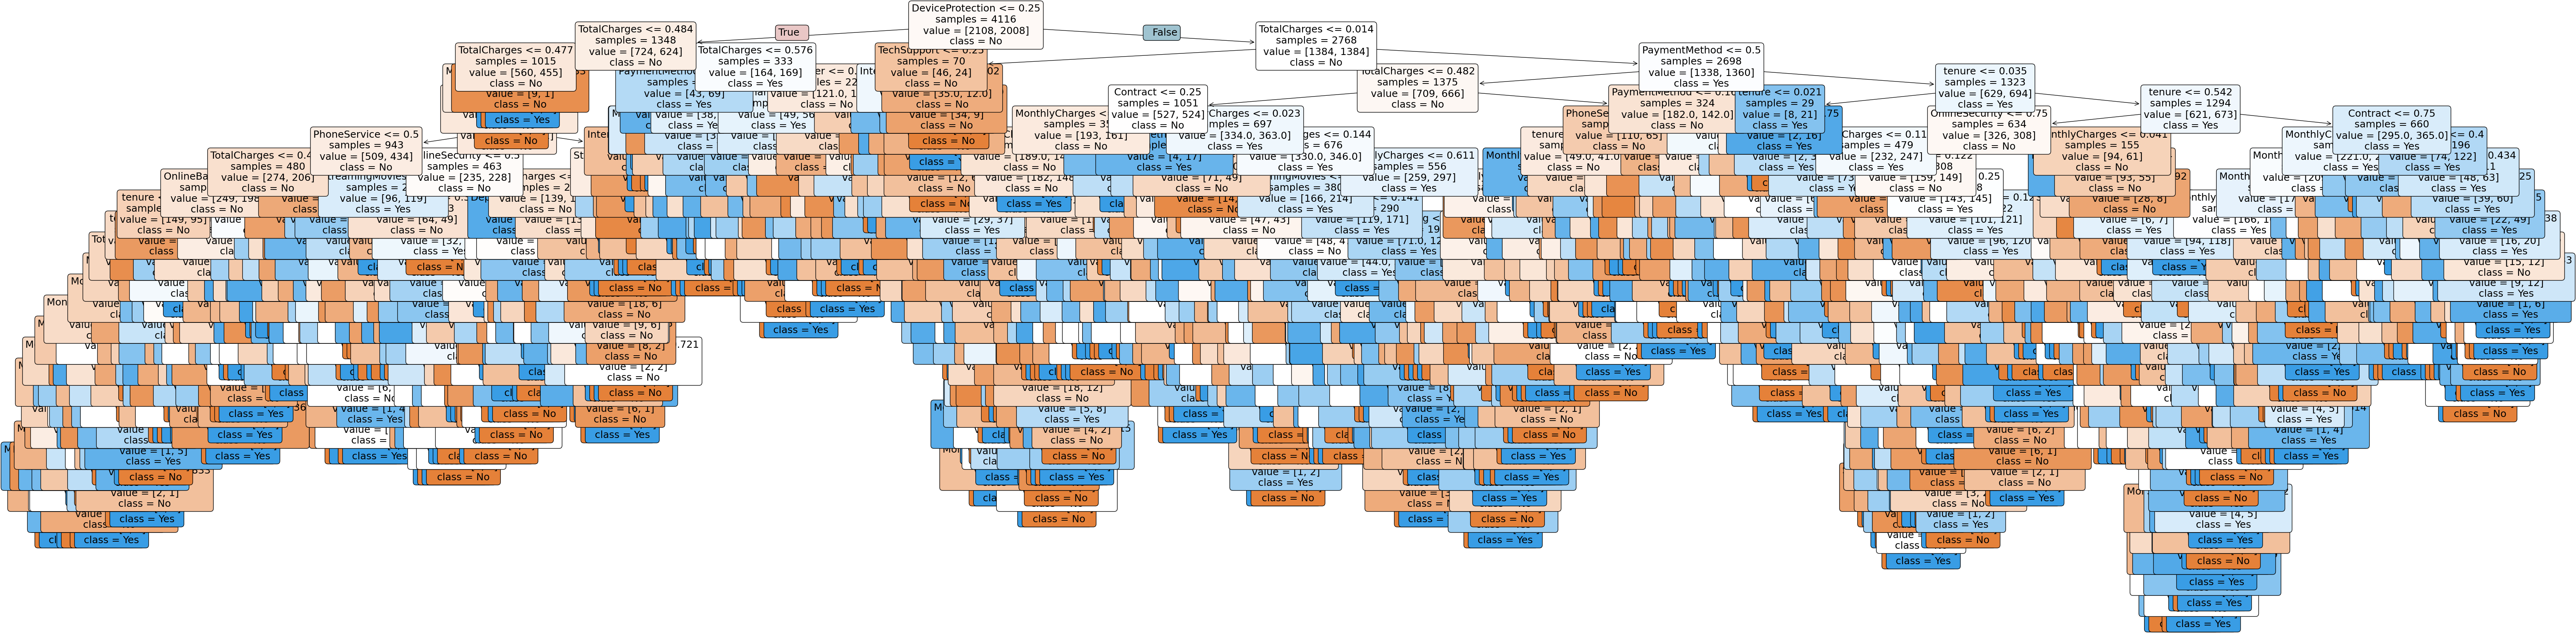

In [250]:
# กำหนดสีของแต่ละคลาส
class_colors = {
	True: '#e9c7c6',
	False: '#9fc3d0',
}

# สร้าง colormap จากสีของแต่ละคลาส
cmap = mcolors.ListedColormap([class_colors[bool(c)] for c in tree_model.classes_])

plt.figure(figsize=(80, 20))
plot_tree(
	tree_model,
	feature_names=preprocessed_dataset.columns[:-1],
	class_names=[str(c) for c in tree_model.classes_],  # Convert classes to strings
	filled=True,
	rounded=True,
	impurity=False,
	proportion=False,  # แสดงจำนวน samples เป็นค่าจริง
	fontsize=18
)

# ปรับสีของโหนด
ax = plt.gca()
for i, t in enumerate(ax.get_children()):
	if isinstance(t, plt.Text):
		for cls, color in class_colors.items():
			if str(cls) in t.get_text():  # Convert cls to string before using 'in'
				t.set_bbox(dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

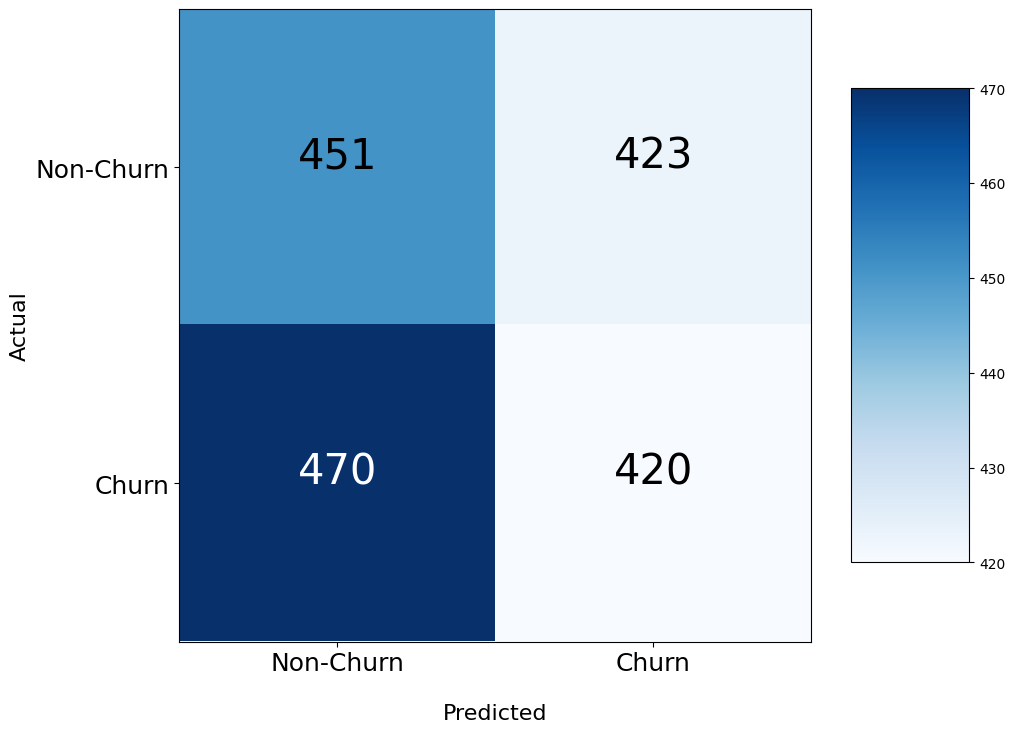

Accuracy: 49.38%


In [251]:
tree_test_predict = tree_model.predict(x_test)

cm = confusion_matrix(y_test, tree_test_predict)
plot_confusion_matrix(cm)
print(f"Accuracy: {accuracy_score(y_test, tree_test_predict) * 100:.2f}%")

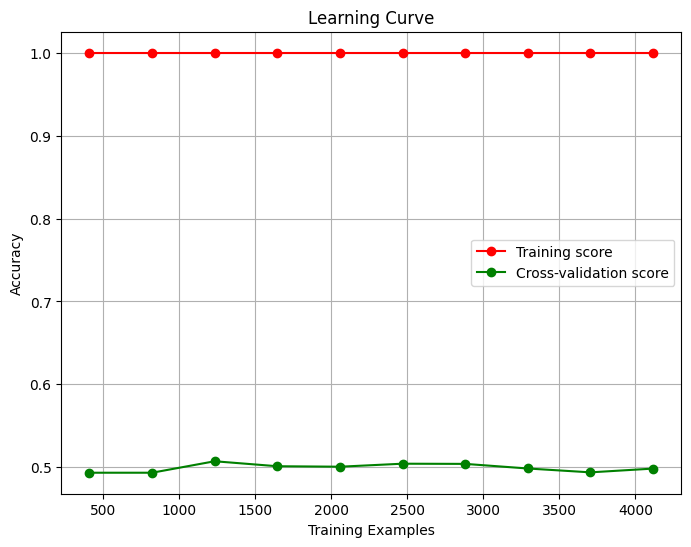

In [252]:
plot_learning_curve(tree_model, x, y)